# Task: Classification
Building classification model using convolution and fully connected layers to classify
CIFAR-10 image dataset

## Imports

In [1]:
import os
from pathlib import Path
import fastprogress
import time

from fastprogress import progress_bar, master_bar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchinfo import summary


torch.set_float32_matmul_precision('high')

### Helper functions

In [2]:
def get_mean_std(dataloader):

    mean = 0.0
    std = 0.0
    for images, _ in dataloader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(dataloader.dataset)
    std /= len(dataloader.dataset)

    return mean, std


def get_device(cuda_id=0):
    use_cuda = torch.cuda.is_available()
    device = torch.device(f'cuda:{cuda_id}' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device


def load_cifar10(path, train, transform=torchvision.transforms.ToTensor()):
    return torchvision.datasets.CIFAR10(path, train=train, download=True, 
                                        transform=transform)


def get_dataLoader(data, batch_size=128, shuffle=False, num_workers=2, collate_fn=None):
    return torch.utils.data.DataLoader(data,batch_size=batch_size,
                                       shuffle=shuffle,num_workers=num_workers,collate_fn=collate_fn)


def show_images(loader, title='', feature_names=None):
    """show 6 images from dataloader"""
    plt.close('all')
    sns.set_theme(
        style='whitegrid',
        rc={'figure.figsize': (12, 5), 'font.size': 14}
    )

    x, y = next(iter(loader))
    idx = np.random.randint(0, x.shape[0], 12)
    fig, ax = plt.subplots(2, 6)
    fig.suptitle(title)

    for axs, i in zip(ax.flatten(), idx):
        if x.shape[1] == 3:
            axs.imshow(x[i].permute(1,2,0))
        else:
            axs.imshow(x[i].permute(1,2,0), cmap='gray')
        axs.axis(False)
        class_name = y[i].item()
        if feature_names is not None:
            class_name = feature_names[class_name]
        axs.set_title(f"{class_name}")

    plt.show()

### CUDA Check

In [3]:
device = get_device()

Using device NVIDIA A100 80GB PCIe


### Paths

In [4]:
path = Path().cwd()

data_folder = path / 'data'
data_folder.mkdir(exist_ok=True)

checkpoint_folder = path / 'checkpoint'
checkpoint_folder.mkdir(exist_ok=True)

data_folder, checkpoint_folder

(PosixPath('/home/ah19/Course Assignments/data'),
 PosixPath('/home/ah19/Course Assignments/checkpoint'))

### Load & normalize data


In [5]:
# load train data
traindata = load_cifar10(data_folder, train=True)

Files already downloaded and verified


In [6]:
# get mean and std for normalization
trainloader = get_dataLoader(traindata)

# calculate manually
# mean_, std_ = get_mean_std(trainloader)

# already calculated
mean_ = torch.tensor((0.4914, 0.4822, 0.4465))
std_ = torch.tensor((0.2023, 0.1994, 0.2010))

mean_, std_

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2023, 0.1994, 0.2010]))

In [7]:
# train transformer with data augmentation
tf_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomCrop(32, 4),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean_, std_)
])

# test transformer
tf_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean_, std_)
])

### EDA

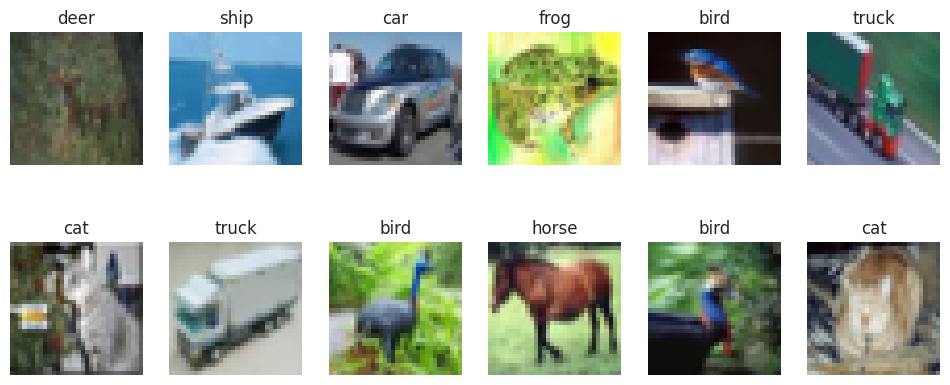

In [8]:
# classes
classes = ['plane', 'car', 'bird',
           'cat', 'deer', 'dog',
           'frog', 'horse', 'ship',
           'truck']

show_images(trainloader, feature_names=classes)

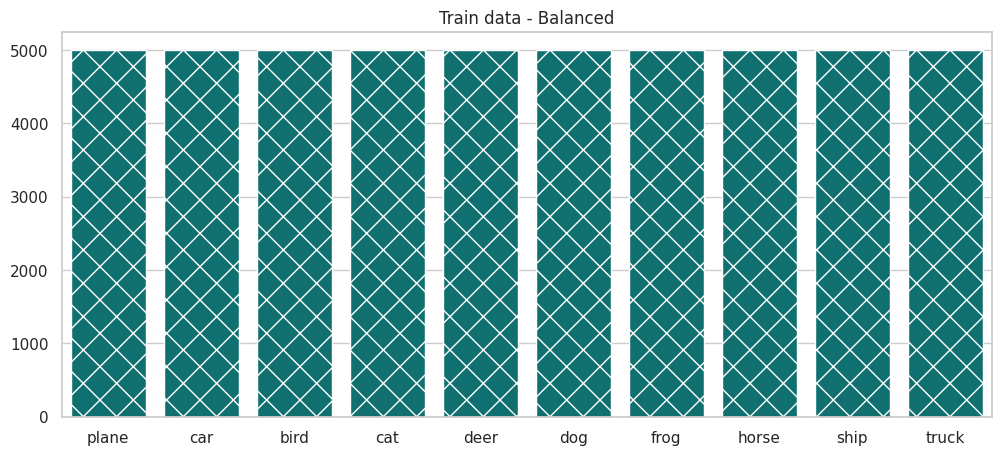

In [9]:
ax = sns.barplot(x=classes, y=np.bincount(traindata.targets, minlength=10), hatch='x', color='teal')
ax.set_title('Train data - Balanced')

plt.show()

### Load train and test

In [10]:
traindata = load_cifar10(data_folder, train=True, transform=tf_train)
testdata =  load_cifar10(data_folder, train=False, transform=tf_test)

Files already downloaded and verified
Files already downloaded and verified


### Model

In [11]:
class Cifar10_Model(nn.Module):
    
    def __init__(self, img_width=32, num_in_channels=3, num_classes=10):
        super(Cifar10_Model, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(num_in_channels, 256, 3, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, 3, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 128, 3, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, 3, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*24*24, 2048, bias=False),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            
            nn.Linear(2048, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )

        # expand all layers in sequential order
        self.output = nn.Linear(1024, num_classes, bias=False)
    

    def forward(self, x):
        x = self.conv(x)
        x = self.linear(x)
        x = self.output(x)
        return x


### Initaite model

In [20]:
model = Cifar10_Model().to(device)
model = torch.compile(model)

In [13]:
# print model summary
# summary(model, (1, 3, 32, 32))

### Optimizer and learning scheduler

In [22]:
lr = 1e-2
epochs = 100
batch_size = 64
patience = 5
optim_name = 'AdamW'
scheduler_name = 'ReduceLROnPlateau'


optimizer = getattr(torch.optim, optim_name)(model.parameters(), lr=lr)
# scheduler = getattr(torch.optim.lr_scheduler, scheduler_name)(optimizer, milestones=[10, 50, 80]) # MultiStepLR
scheduler = getattr(torch.optim.lr_scheduler, scheduler_name)(optimizer, mode='max', patience=patience, min_lr=1e-6)

### Dataloaders

In [23]:
trainloader = get_dataLoader(traindata, batch_size=batch_size, shuffle=True)
testloader = get_dataLoader(testdata, batch_size=batch_size, shuffle=False)

### Loss function

In [24]:
cost_fn = nn.CrossEntropyLoss()

### Train and Test

In [25]:
losses = []
accuracies = []

best_accuracy = 0.0
best_loss = 1.0
current_accuracy = 0.0
current_patience = 0

mb = master_bar(range(epochs))

for epoch in mb:

    model.train()
    train_loss = 0.0
    
    for x, y in progress_bar(trainloader, parent=mb):
        
        mb.child.comment = "Training"
        
        # Move tensors to device
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        outputs = model(x)
        loss = cost_fn(outputs, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Testing phase
    model.eval()
    total_correct = 0
    total_number = 0
    with torch.no_grad():
        for x, y in progress_bar(testloader, parent=mb):
            
            mb.child.comment = "Testing"
        
            # Move tensors to device
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            loss = cost_fn(outputs, y)
            _, predicted = torch.max(outputs.data, 1)
            total_number += y.size(0)
            total_correct += (predicted == y).sum().item()

    # calculate accuracy
    current_accuracy = 100 * total_correct / total_number
    
    # append test accuracy and loss
    accuracies.append(current_accuracy)
    losses.append(loss.item())
    
    # check improvement in accuracy and patiens
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_loss = loss.item()
        current_patience = 0
        torch.save(model.state_dict(), checkpoint_folder / f'cifar10-checkpoint.pth.tar')
        
#     else:
#         current_patience += 1

#     # early stop
#     if current_patience == patience or best_accuracy > 97.0:
#         mb.write('Early Stop!')
#         break
        
    # ctep scheduler
    scheduler.step(current_accuracy)
        
    # Print epoch information
#     mb.write(f"Epoch [{epoch+1:03}], LR: {scheduler.get_last_lr()[0]:.1e}, Accuracy: {current_accuracy:.2f}%, Loss: {loss.item():.2f}%")
    mb.write(f"Epoch [{epoch+1:03}], LR: {optimizer.param_groups[0]['lr']:.1e}, Accuracy: {current_accuracy:.2f}%, Loss: {loss.item():.2f}%")

print(f"Best Accuracy: {best_accuracy:.2f}%")

Best Accuracy: 91.00%


In [26]:
# rename checkpoint
best_model = checkpoint_folder / f'cifar10-checkpoint.pth.tar'
best_model.rename(checkpoint_folder / f'cifar10-checkpoint-acc_{best_accuracy:.2f}-loss{best_loss:.2f}.pth.tar')

PosixPath('/home/ah19/Course Assignments/checkpoint/cifar10-checkpoint-acc_91.00-loss0.22.pth.tar')

### Plot accuracy and loss

In [78]:
best_epoch_idx = np.argmax(accuracies)

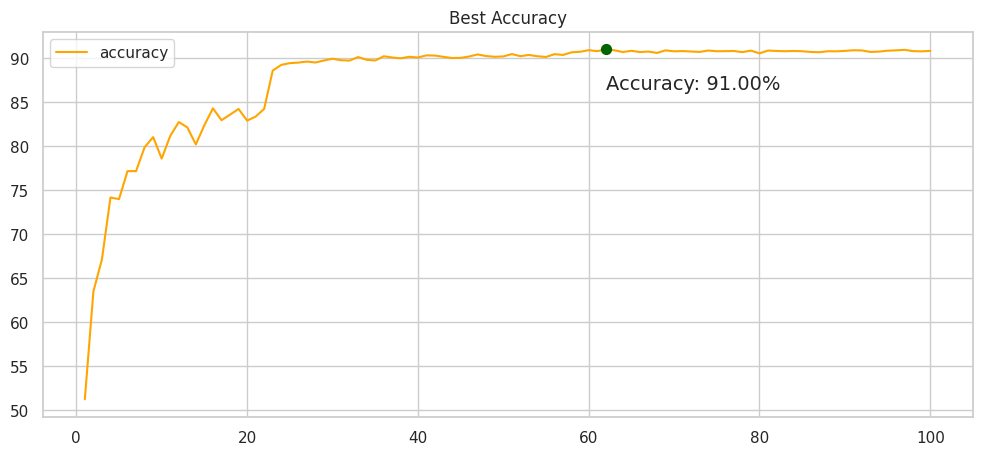

In [90]:
ax = pd.DataFrame({'accuracy': accuracies}, index=range(1, len(accuracies)+1)) \
    .plot(title='Best Accuracy', color='orange')

ax.scatter(x=best_epoch_idx+1, y=accuracies[best_epoch_idx], color='darkgreen', s=50, marker='o', zorder=3)
ax.annotate(f'Accuracy: {accuracies[best_epoch_idx]:.2f}%', (best_epoch_idx+1, accuracies[best_epoch_idx]*0.95))

plt.show()

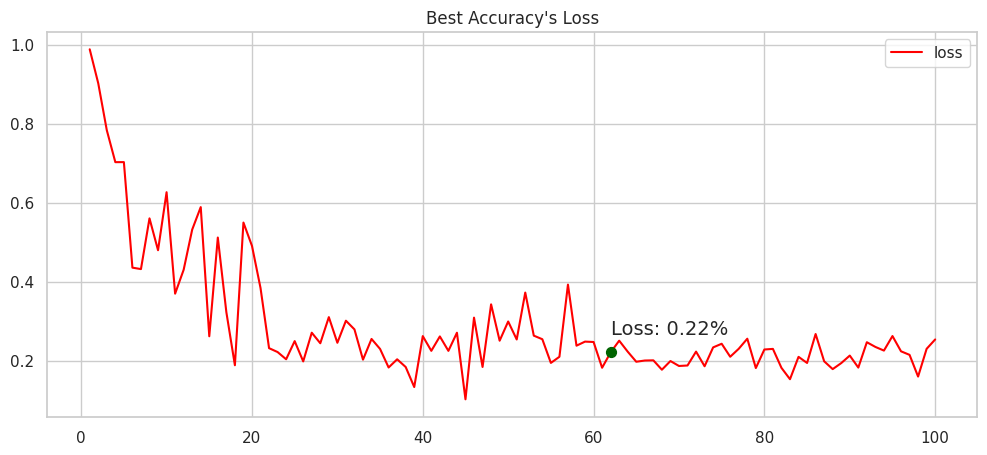

In [89]:
ax = pd.DataFrame({'loss': losses}, index=range(1, len(accuracies)+1)) \
    .plot(title='Best Accuracy\'s Loss', color='red')

ax.scatter(x=best_epoch_idx+1, y=losses[best_epoch_idx], color='darkgreen', s=50, marker='o', zorder=3)
ax.annotate(f'Loss: {losses[best_epoch_idx]:.2f}%', (best_epoch_idx+1, losses[best_epoch_idx]*1.2))

plt.show()